In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
df.dtypes
# df.select_dtypes('object').nunique()

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [14]:
X = df.drop('diabetes', axis=1)
y = pd.DataFrame(df['diabetes'])

num_cols = list(X.select_dtypes('number').keys())
cat_cols = list(X.select_dtypes('object').keys())

sample_row = X.loc[0].to_dict()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pileline', num_pipeline, num_cols),
    ('cat_pileline', cat_pipeline, cat_cols)
])

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', model)
])  

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid, preds)}')


accuracy: 0.9700333333333333


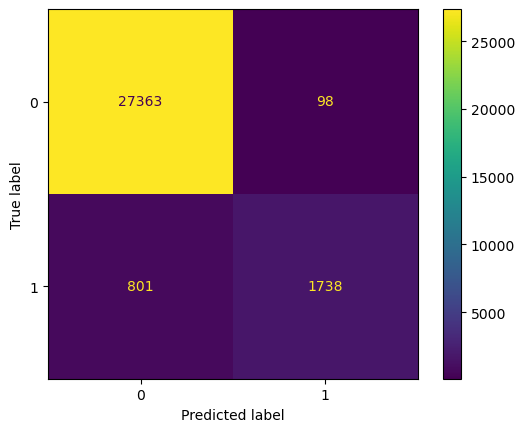

In [13]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

In [17]:
from pydantic import BaseModel, ValidationError

class Patient(BaseModel):
    gender: object
    age: float
    hypertension: int
    heart_disease: int
    smoking_history: object
    bmi: float
    HbA1c_level: float
    blood_glucose_level: int
    
print(sample_row)
Patient(**sample_row)

{'gender': 'Female', 'age': 80.0, 'hypertension': 0, 'heart_disease': 1, 'smoking_history': 'never', 'bmi': 25.19, 'HbA1c_level': 6.6, 'blood_glucose_level': 140}


Patient(gender='Female', age=80.0, hypertension=0, heart_disease=1, smoking_history='never', bmi=25.19, HbA1c_level=6.6, blood_glucose_level=140)

In [ ]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        patient = Patient(**request.json)
        inputs = pd.DataFrame([patient.model_dump()])
        pred = pipeline.predict(inputs)[0]
        response = {
            'prediction': int(pred) 
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
[2024-10-09 09:00:53,030] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/flask/app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^